In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math


from py_wake.wind_farm_models import All2AllIterative
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.flow_map import XZGrid
from py_wake.flow_map import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite

from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020

from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing


import h5py
import xarray as xr

import time

In [2]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9   #wind speed
YD=0   #yaw direction
TI=0   #turbulence intensity


#site
site= UniformWeibullSite(p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205],  # sector frequencies
                               a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803],          # Weibull scale parameter
                               k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172],          # Weibull shape parameter
                               ti=TI                          # turbulence intensity, optional
                               )



from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

u=[3,4.06,5,6.15,7.16,8.18,9.027,10.21,11.17,12.26,13.47,14.1,15.47]
ct=[0.88,0.8843,0.8828,0.887,0.8872,0.8899,0.89,0.8,0.58,0.406,0.2933,0.2518,0.1835]
power=[474,1176,2194,4094,6414,9562,12840,19310,22000,22000,22000,22000,22000]

windTurbines = WindTurbine(name='MyWT',
                    diameter=D,
                    hub_height=H,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))


simulation_data_xy = np.loadtxt('101_IEA22MW_baseline_new_xy.txt')


from py_wake.turbulence_models import GCLTurbulence
def get_velocity_field_xy(model=None, grid=XYGrid(x=np.linspace(0, 4400, 440), y=np.linspace(-1400 ,1400, 280), h=H)):
    wfm = All2AllIterative(site, windTurbines, wake_deficitModel=model,blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    result = wfm(x=[0], y=[0], wd=WD, ws=WS, yaw=YD).flow_map(grid)
    return result.WS_eff.values.squeeze()






In [3]:

wf_model2=Blondel_Cathelain_2020(site,windTurbines,turbulenceModel=GCLTurbulence())


sim_res = wf_model2(x=[0], y=[0],     # wind turbine positions
                   h=H,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=WD,  # Wind direction
                   ws=WS,  # Wind speed
                  )

CT=sim_res.CT.values.squeeze()

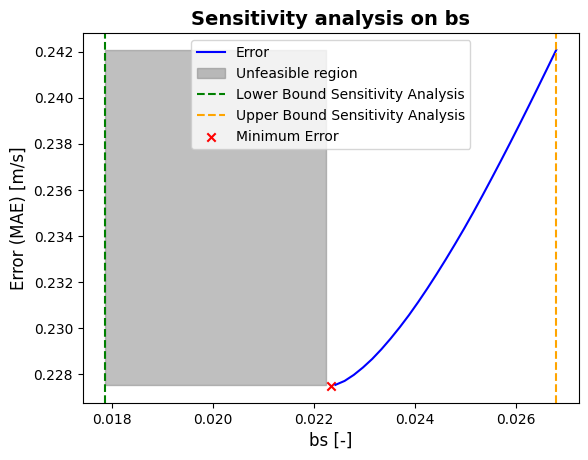

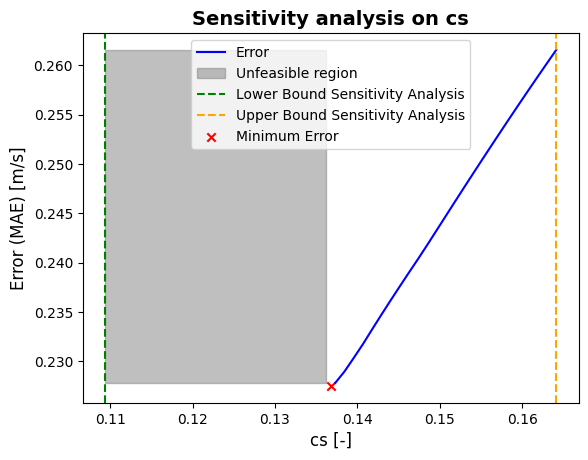

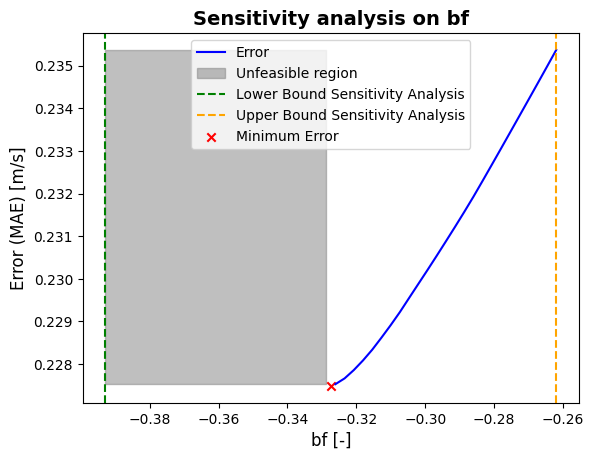

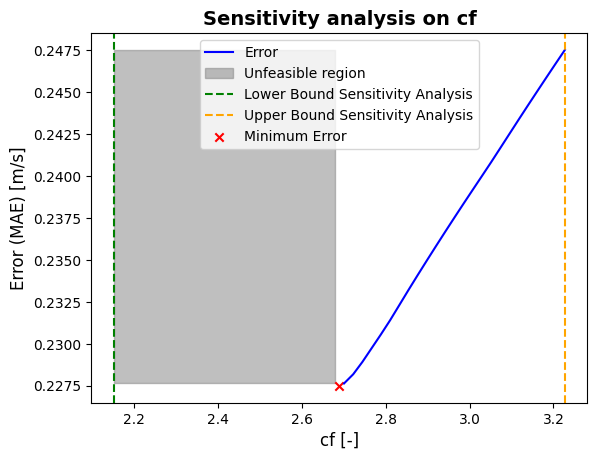

In [6]:
def objective_function_sensitivity_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return tot
params= np.loadtxt('superG_best_params_101_IEA22MW_baseline_new_xy.txt')
solution_xy=np.loadtxt('superG_best_sol_101_IEA22MW_baseline_new_xy.txt')


as_opt=0
bs_opt=params[0]
cs_opt=params[1]
bf_opt=params[2]
cf_opt=params[3]

bs_sensitivity=np.linspace(bs_opt - 0.2 * abs(bs_opt), bs_opt + 0.2 * abs(bs_opt),50)
cs_sensitivity=np.linspace(cs_opt - 0.2 * abs(cs_opt), cs_opt + 0.2 * abs(cs_opt),50)
bf_sensitivity=np.linspace(bf_opt - 0.2 * abs(bf_opt), bf_opt + 0.2 * abs(bf_opt),50)
cf_sensitivity=np.linspace(cf_opt - 0.2 * abs(cf_opt), cf_opt + 0.2 * abs(cf_opt),50)

sol = solution_xy



error_bs_s=np.zeros(len(bs_sensitivity))
for i in range(len(bs_sensitivity)):
    bs_s=bs_sensitivity[i]
    as_s=as_opt
    cs_s=cs_opt
    bf_s=bf_opt
    cf_s=cf_opt

    error_bs_s[i]=objective_function_sensitivity_xy([bs_s,cs_s,bf_s,cf_s])

nan_indices = np.isnan(error_bs_s)
filled_region_x = bs_sensitivity[nan_indices]
filled_region_y_min = min(error_bs_s[~nan_indices])  # Minimum value of error_bs_s excluding NaNs
filled_region_y_max = max(error_bs_s[~nan_indices])  # Maximum value of error_bs_s excluding NaNs

# Plot the error curve
plt.plot(bs_sensitivity, error_bs_s, linestyle='-', color='b', label='Error')

# Fill the region where error_bs_s is NaN
if np.any(nan_indices):
    plt.fill_between(filled_region_x, filled_region_y_min, filled_region_y_max, color='grey', alpha=0.5, label='Unfeasible region')

# Add other plot customizations
plt.xlabel('bs [-]', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Sensitivity analysis on bs', fontsize=14, fontweight='bold')
plt.axvline(x=bs_sensitivity[0], linestyle='--', color='green', label='Lower Bound Sensitivity Analysis')
plt.axvline(x=bs_sensitivity[-1], linestyle='--', color='orange', label='Upper Bound Sensitivity Analysis')
plt.scatter(bs_opt, sol, color='red', label='Minimum Error', marker='x')
plt.legend()
plt.show()



error_cs_s=np.zeros(len(cs_sensitivity))
for i in range(len(cs_sensitivity)):
    cs_s=cs_sensitivity[i]
    as_s=as_opt
    bs_s=bs_opt
    bf_s=bf_opt
    cf_s=cf_opt

    error_cs_s[i]=objective_function_sensitivity_xy([bs_s,cs_s,bf_s,cf_s])



nan_indices = np.isnan(error_cs_s)
filled_region_x = cs_sensitivity[nan_indices]
filled_region_y_min = min(error_cs_s[~nan_indices])  # Minimum value of error_bs_s excluding NaNs
filled_region_y_max = max(error_cs_s[~nan_indices])  # Maximum value of error_bs_s excluding NaNs

# Plot the error curve
plt.plot(cs_sensitivity, error_cs_s, linestyle='-', color='b', label='Error')

# Fill the region where error_bs_s is NaN
if np.any(nan_indices):
    plt.fill_between(filled_region_x, filled_region_y_min, filled_region_y_max, color='grey', alpha=0.5, label='Unfeasible region')

# Add other plot customizations
plt.xlabel('cs [-]', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Sensitivity analysis on cs', fontsize=14, fontweight='bold')
plt.axvline(x=cs_sensitivity[0], linestyle='--', color='green', label='Lower Bound Sensitivity Analysis')
plt.axvline(x=cs_sensitivity[-1], linestyle='--', color='orange', label='Upper Bound Sensitivity Analysis')
plt.scatter(cs_opt, sol, color='red', label='Minimum Error', marker='x')
plt.legend()
plt.show()

error_bf_s=np.zeros(len(bf_sensitivity))
for i in range(len(bf_sensitivity)):
    bf_s=bf_sensitivity[i]
    as_s=as_opt
    cs_s=cs_opt
    bs_s=bs_opt
    cf_s=cf_opt

    error_bf_s[i]=objective_function_sensitivity_xy([bs_s,cs_s,bf_s,cf_s])


nan_indices = np.isnan(error_bf_s)
filled_region_x = bf_sensitivity[nan_indices]
filled_region_y_min = min(error_bf_s[~nan_indices])  # Minimum value of error_bs_s excluding NaNs
filled_region_y_max = max(error_bf_s[~nan_indices])  # Maximum value of error_bs_s excluding NaNs

# Plot the error curve
plt.plot(bf_sensitivity, error_bf_s, linestyle='-', color='b', label='Error')

# Fill the region where error_bs_s is NaN
if np.any(nan_indices):
    plt.fill_between(filled_region_x, filled_region_y_min, filled_region_y_max, color='grey', alpha=0.5, label='Unfeasible region')

# Add other plot customizations
plt.xlabel('bf [-]', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Sensitivity analysis on bf', fontsize=14, fontweight='bold')
plt.axvline(x=bf_sensitivity[0], linestyle='--', color='green', label='Lower Bound Sensitivity Analysis')
plt.axvline(x=bf_sensitivity[-1], linestyle='--', color='orange', label='Upper Bound Sensitivity Analysis')
plt.scatter(bf_opt, sol, color='red', label='Minimum Error', marker='x')
plt.legend()
plt.show()

error_cf_s=np.zeros(len(cf_sensitivity))
for i in range(len(cf_sensitivity)):
    cf_s=cf_sensitivity[i]
    as_s=as_opt
    cs_s=cs_opt
    bf_s=bf_opt
    bs_s=bs_opt

    error_cf_s[i]=objective_function_sensitivity_xy([bs_s,cs_s,bf_s,cf_s])



nan_indices = np.isnan(error_cf_s)
filled_region_x = cf_sensitivity[nan_indices]
filled_region_y_min = min(error_cf_s[~nan_indices])  # Minimum value of error_bs_s excluding NaNs
filled_region_y_max = max(error_cf_s[~nan_indices])  # Maximum value of error_bs_s excluding NaNs

# Plot the error curve
plt.plot(cf_sensitivity, error_cf_s, linestyle='-', color='b', label='Error')

# Fill the region where error_bs_s is NaN
if np.any(nan_indices):
    plt.fill_between(filled_region_x, filled_region_y_min, filled_region_y_max, color='grey', alpha=0.5, label='Unfeasible region')

# Add other plot customizations
plt.xlabel('cf [-]', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Sensitivity analysis on cf', fontsize=14, fontweight='bold')
plt.axvline(x=cf_sensitivity[0], linestyle='--', color='green', label='Lower Bound Sensitivity Analysis')
plt.axvline(x=cf_sensitivity[-1], linestyle='--', color='orange', label='Upper Bound Sensitivity Analysis')
plt.scatter(cf_opt, sol, color='red', label='Minimum Error', marker='x')
plt.legend()
plt.show()


In [5]:
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.sample import saltelli
from SALib.sample import sobol
from SALib.analyze import sobol

best_params= np.loadtxt('superG_best_params_101_IEA22MW_baseline_new_xy.txt')

x_tilde=1/D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))
def objective_function_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f
    tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))
    if math.isnan(tot):
        return 10**36
    else:
        if np.any(sigma < 0) or np.any(n < 2):
            return 10**36
        else:
            return tot



names = ['bs', 'cs', 'bf', 'cf']
bounds = [
    [best_params[0] - 0.2 * abs(best_params[0]), best_params[0] + 0.2 * abs(best_params[0])],
    [best_params[1] - 0.2 * abs(best_params[1]), best_params[1] + 0.2 * abs(best_params[1])],
    [best_params[2] - 0.2 * abs(best_params[2]), best_params[2] + 0.2 * abs(best_params[2])],
    [best_params[3] - 0.2* abs(best_params[3]), best_params[3] + 0.2 * abs(best_params[3])]
]

problem = {
    'num_vars': len(names),
    'names': names,
    'bounds': bounds,
    'outputs': ['Y']
}

# Define the number of samples
#N = 3000
N=4096

# Generate Saltelli samples
param_values_saltelli = saltelli.sample(problem, N)

# Initialize arrays to store valid parameter values and corresponding model outputs
valid_param_values = []
valid_model_outputs = []

# Evaluate the model for each sample of parameter values
for param in param_values_saltelli:
    model_output = objective_function_xy(param)
    if not isinstance(model_output, float) or not np.isnan(model_output):
        valid_param_values.append(param)
        valid_model_outputs.append(model_output)

# Convert the lists to numpy arrays
valid_param_values = np.array(valid_param_values)
valid_model_outputs = np.array(valid_model_outputs)

# Perform sensitivity analysis using the Sobol' method
sobol_indices_saltelli = sobol.analyze(problem, valid_model_outputs)

# Print the first-order and total sensitivity indices
print("First-order indices with Saltelli (excluding NaN values):", sobol_indices_saltelli['S1'])
print("Total indices with Saltelli (excluding NaN values):", sobol_indices_saltelli['ST'])

#np.savetxt('sensitivity_S1_xy_7ms.txt',sobol_indices_saltelli['S1'])
#np.savetxt('sensitivity_ST_xy_7ms.txt',sobol_indices_saltelli['ST'])


C:\Users\asus\AppData\Local\Temp\ipykernel_22280\320287556.py:51: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_saltelli = saltelli.sample(problem, N)
c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


First-order indices with Saltelli (excluding NaN values): [0.0263547  0.57435051 0.02344454 0.11815875]
Total indices with Saltelli (excluding NaN values): [0.14848211 0.87917041 0.13089871 0.36534415]


In [14]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol

x_tilde=1/D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))
simulation_data_xy = np.loadtxt('200_baseline_11ms_xy.txt') #put respective simulation data
WS=11 #put correct wind speed tested
CT=sim_res.CT.values.squeeze()
def objective_function_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f
    tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))
    if math.isnan(tot):
        return 10**36
    else:
        if np.any(sigma < 0) or np.any(n < 2):
            return 10**36
        else:
            return tot




# Load best_params and define other necessary variables
best_params = np.loadtxt('200_11ms_xy.txt')
names = ['bs', 'cs', 'bf', 'cf']
bounds = [
    [best_params[0] - 0.2 * abs(best_params[0]), best_params[0] + 0.2 * abs(best_params[0])],
    [best_params[1] - 0.2 * abs(best_params[1]), best_params[1] + 0.2 * abs(best_params[1])],
    [best_params[2] - 0.2 * abs(best_params[2]), best_params[2] + 0.2 * abs(best_params[2])],
    [best_params[3] - 0.2* abs(best_params[3]), best_params[3] + 0.2 * abs(best_params[3])]
]

problem = {
    'num_vars': len(names),
    'names': names,
    'bounds': bounds,
    'outputs': ['Y']
}

# Define the number of samples
#N = 3000
N=2048

# Generate Saltelli samples
param_values_saltelli = saltelli.sample(problem, N)

# Initialize arrays to store valid parameter values and corresponding model outputs
valid_param_values = []
valid_model_outputs = []

# Evaluate the model for each sample of parameter values
for param in param_values_saltelli:
    model_output = objective_function_xy(param)
    if not isinstance(model_output, float) or not np.isnan(model_output):
        valid_param_values.append(param)
        valid_model_outputs.append(model_output)

# Convert the lists to numpy arrays
valid_param_values = np.array(valid_param_values)
valid_model_outputs = np.array(valid_model_outputs)

# Perform sensitivity analysis using the Sobol' method
sobol_indices_saltelli = sobol.analyze(problem, valid_model_outputs)

# Print the first-order and total sensitivity indices
print("First-order indices with Saltelli (excluding NaN values):", sobol_indices_saltelli['S1'])
print("Total indices with Saltelli (excluding NaN values):", sobol_indices_saltelli['ST'])

np.savetxt('sensitivity_S1_xy_11ms.txt',sobol_indices_saltelli['S1'])
np.savetxt('sensitivity_ST_xy_11ms.txt',sobol_indices_saltelli['ST'])

C:\Users\asus\AppData\Local\Temp\ipykernel_46532\4166548979.py:53: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_saltelli = saltelli.sample(problem, N)


First-order indices with Saltelli (excluding NaN values): [0.02050599 0.2519673  0.0468714  0.29980526]
Total indices with Saltelli (excluding NaN values): [0.20996274 0.63086479 0.21875188 0.62988822]


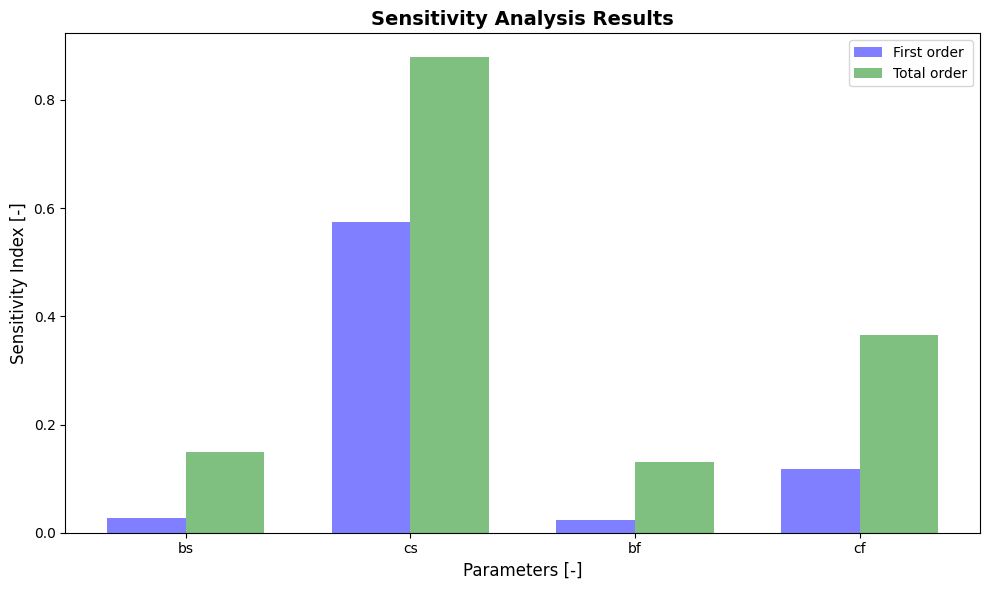

In [10]:

S1 = np.array([0.0263547 , 0.57435051 ,0.02344454 ,0.11815875])
ST = np.array([0.14848211, 0.87917041, 0.13089871, 0.36534415])

parameters = ['bs', 'cs', 'bf', 'cf']

# Define bar width
bar_width = 0.35

# Define the positions for the bars
index = np.arange(len(parameters))

# Create bar plot
plt.figure(figsize=(10, 6))

# Plotting S1
plt.bar(index - bar_width/2, S1, label='First order', color='blue', alpha=0.5, width=bar_width)

# Plotting ST
plt.bar(index + bar_width/2, ST, label='Total order', color='green', alpha=0.5, width=bar_width)

plt.xlabel('Parameters [-]', fontsize=12)
plt.ylabel('Sensitivity Index [-]', fontsize=12)
plt.title('Sensitivity Analysis Results', fontsize=14, fontweight='bold')

# Adjust the legend to show correct colors
plt.legend()

plt.xticks(index, parameters)  # Adjust the x-axis ticks
plt.tight_layout()
plt.show()

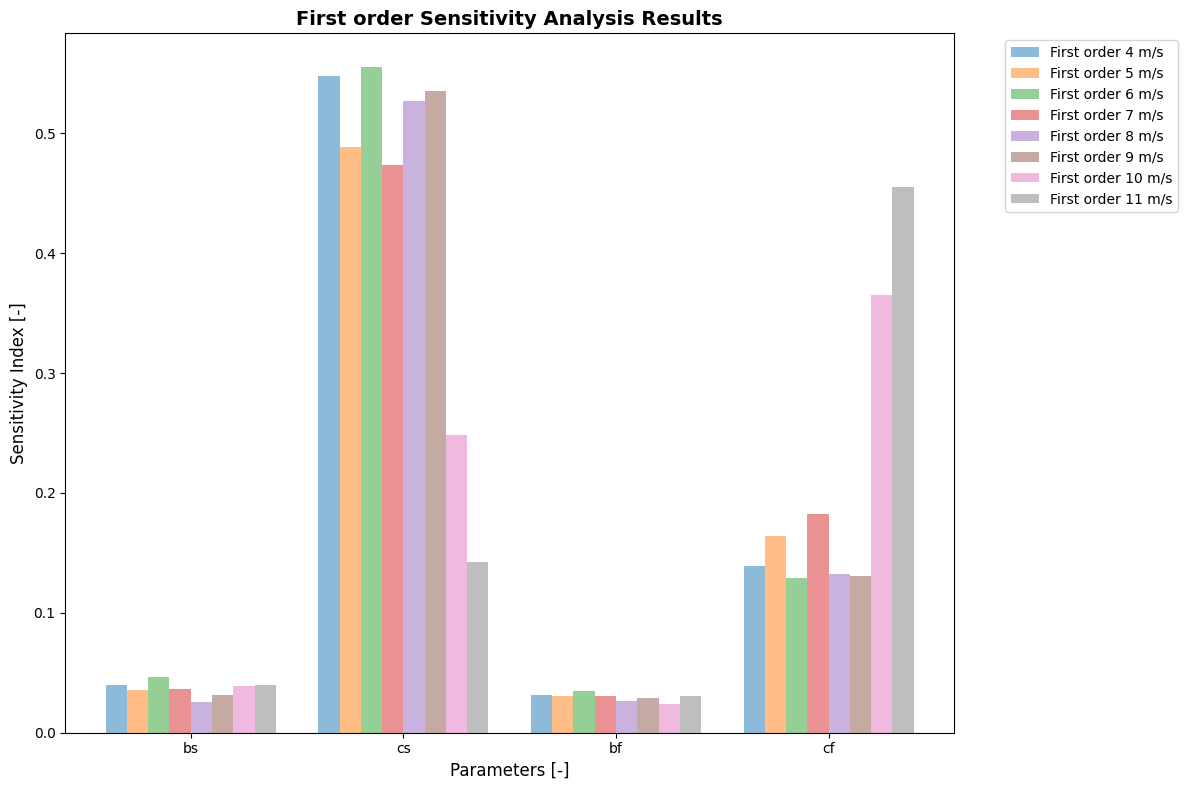

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load sensitivity indices from files (sensitivity analysis already performed)
S1_1 = np.loadtxt('sensitivity_S1_xy_4ms.txt')
S1_2 = np.loadtxt('sensitivity_S1_xy_5ms.txt')
S1_3 = np.loadtxt('sensitivity_S1_xy_6ms.txt')
S1_4 = np.loadtxt('sensitivity_S1_xy_7ms.txt')
S1_5 = np.loadtxt('sensitivity_S1_xy_8ms.txt')
S1_6 = np.loadtxt('sensitivity_S1_xy_9ms.txt')
S1_7 = np.loadtxt('sensitivity_S1_xy_10ms.txt')
S1_8 = np.loadtxt('sensitivity_S1_xy_11ms.txt')




# Combine sensitivity indices into sets
S1_sets = [S1_1, S1_2, S1_3,S1_4,S1_5,S1_6,S1_7,S1_8]


# Parameter names
parameters = ['bs', 'cs', 'bf', 'cf']

# Define bar width
bar_width = 0.1

# Define the positions for the bars
index = np.arange(len(parameters))

# Create bar plot
plt.figure(figsize=(12, 8))

# Plotting each set of sensitivity indices
for i in range(len(S1_sets)):
    plt.bar(index + i * bar_width, S1_sets[i], label=f'First order {i+4} m/s', width=bar_width, alpha=0.5)


plt.xlabel('Parameters [-]', fontsize=12)
plt.ylabel('Sensitivity Index [-]', fontsize=12)
plt.title('First order Sensitivity Analysis Results', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width * (len(S1_sets) - 1) / 2, parameters)  # Adjust the x-axis ticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


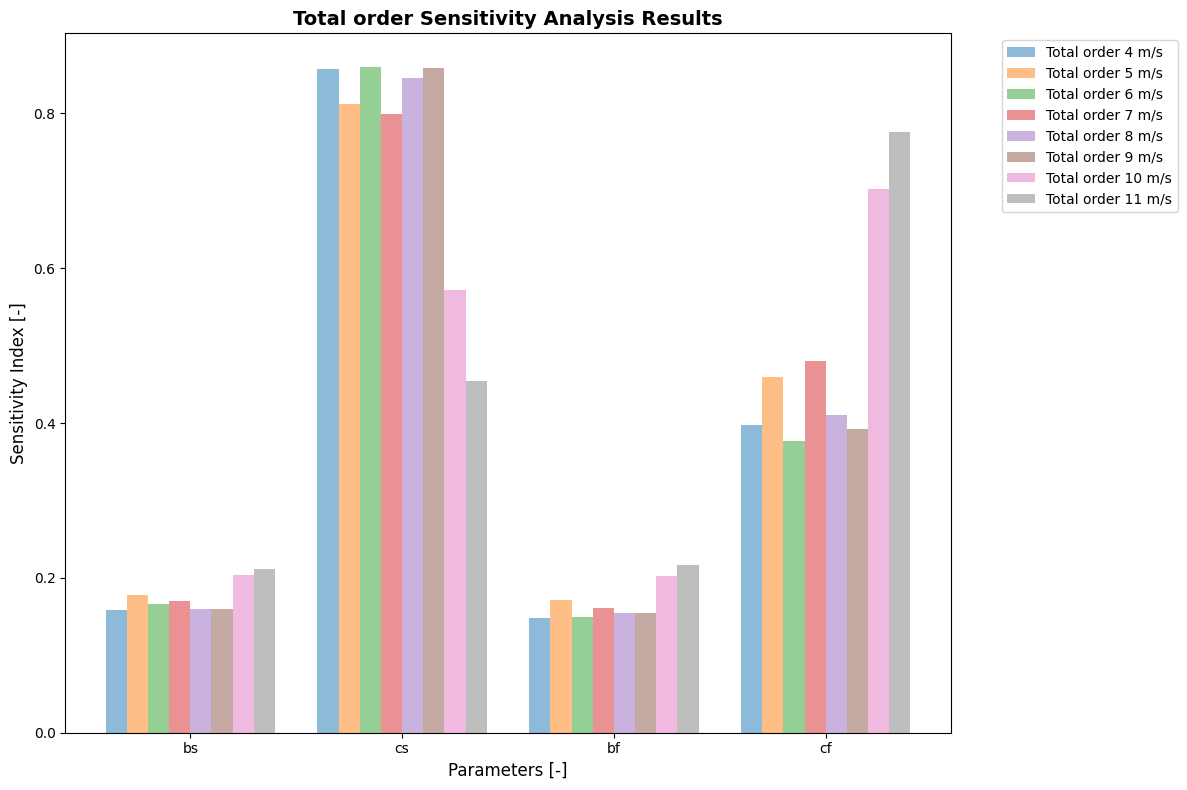

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load sensitivity indices from files


ST_1 = np.loadtxt('sensitivity_ST_xy_4ms.txt')
ST_2 = np.loadtxt('sensitivity_ST_xy_5ms.txt')
ST_3 = np.loadtxt('sensitivity_ST_xy_6ms.txt')
ST_4 = np.loadtxt('sensitivity_ST_xy_7ms.txt')
ST_5 = np.loadtxt('sensitivity_ST_xy_8ms.txt')
ST_6 = np.loadtxt('sensitivity_ST_xy_9ms.txt')
ST_7 = np.loadtxt('sensitivity_ST_xy_10ms.txt')
ST_8 = np.loadtxt('sensitivity_ST_xy_11ms.txt')


# Combine sensitivity indices into sets

ST_sets = [ST_1, ST_2, ST_3,ST_4,ST_5,ST_6,ST_7,ST_8]

# Parameter names
parameters = ['bs', 'cs', 'bf', 'cf']

# Define bar width
bar_width = 0.1

# Define the positions for the bars
index = np.arange(len(parameters))

# Create bar plot
plt.figure(figsize=(12, 8))

# Plotting each set of sensitivity indices
for i in range(len(S1_sets)):

    plt.bar(index + i * bar_width, ST_sets[i], label=f'Total order {i+4} m/s', width=bar_width, alpha=0.5)

plt.xlabel('Parameters [-]', fontsize=12)
plt.ylabel('Sensitivity Index [-]', fontsize=12)
plt.title('Total order Sensitivity Analysis Results', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width * (len(S1_sets) - 1) / 2, parameters)  # Adjust the x-axis ticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()